In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [3]:

# Hyperparameters

image_size = 784
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train = False,
                                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

sample_dir = 'results'


In [5]:
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)


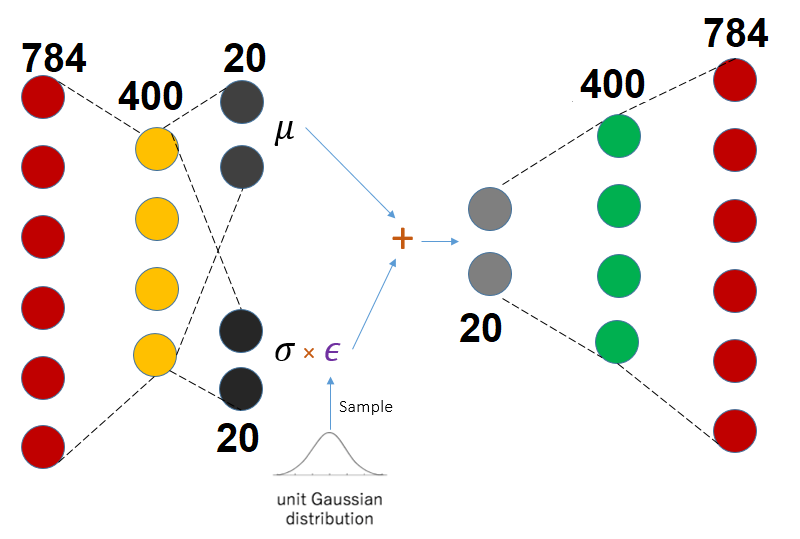

In [15]:
# Variational Auto Encoder
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(image_size, hidden_dim)
    self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
    self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, image_size)

  def encode(self, x):
    h = F.relu(self.fc1(x))
    mu = self.fc2_mean(h)
    log_var = self.fc2_logvar(h)
    return mu, log_var


  def reparameterize(self, mu, logvar):
    std = torch.exp(logvar / 2) # As there might be a log value in the input so to cancel it out we can wrap it with exp fun.
    eps = torch.randn_like(std) # normal distribution randn_like --> shape of std matrix in normal dist
    return mu + eps * std # mean + (epsilon * standard_deviation)

  def decode(self, z):
    h = F.relu(self.fc3(z))
    out = torch.sigmoid(self.fc4(h))
    return out


  def forward(self, x):
    # shape of x is 28, 28, 1 --> flatten 784
    mu, logvar = self.encode(x.view(-1, image_size))
    z = self.reparameterize(mu, logvar)
    reconstructed = self.decode(z)
    return reconstructed, mu, logvar

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



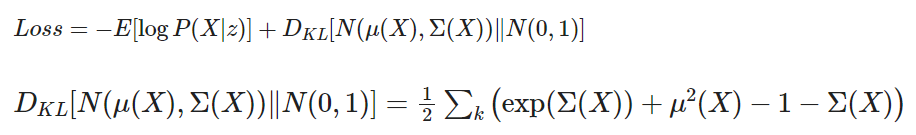

In [16]:
# Define Loss function
def loss_function(reconstructed_image, original_image, mu, logvar):
  bce = F.binary_cross_entropy(reconstructed_image, original_image.view(-1, 784), reduction='sum')
  kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
  return bce + kld

# Train function
def train(epoch):
  model.train()
  train_loss = 0
  for i, (images, _) in enumerate(train_loader):
    images = images.to(device)
    reconstructed, mu, logvar = model(images)
    loss = loss_function(reconstructed, images, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    train_loss += loss.item()
    optimizer.step()


    if i % 100 == 0:
      print("Train Epoch {} [Batch {} / {}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), loss.item() / len(images)))

  print("=====> Epoch {}, Average Loss: {:.3f}".format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for batch_idx, (images, _) in enumerate(test_loader):
      images = images.to(device)
      reconstructed, mu, logvar = model(images)
      test_loss += loss_function(reconstructed, images, mu, logvar).item()
      if batch_idx == 0:
        comparison = torch.cat([images[:5], reconstructed.view(batch_size, 1, 28, 28)[:5]])
        save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=5)

  print("====> Average Test Loss: {:.3f}".format(test_loss/len(test_loader.dataset)))


In [17]:
for epoch in range(1, epochs + 1):
  train(epoch)
  test(epoch)
  with torch.no_grad():
    # We will call only decoder and pass in the sample image from normal distribution
    sample = torch.randn(64, 20).to(device)
    generated = model.decode(sample).cpu()
    save_image(generated.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')

Train Epoch 1 [Batch 0 / 469]	Loss: 551.281
Train Epoch 1 [Batch 100 / 469]	Loss: 189.526
Train Epoch 1 [Batch 200 / 469]	Loss: 158.394
Train Epoch 1 [Batch 300 / 469]	Loss: 141.694
Train Epoch 1 [Batch 400 / 469]	Loss: 133.307
=====> Epoch 1, Average Loss: 165.848
====> Average Test Loss: 128.023
Train Epoch 2 [Batch 0 / 469]	Loss: 131.003
Train Epoch 2 [Batch 100 / 469]	Loss: 122.259
Train Epoch 2 [Batch 200 / 469]	Loss: 126.849
Train Epoch 2 [Batch 300 / 469]	Loss: 127.872
Train Epoch 2 [Batch 400 / 469]	Loss: 115.341
=====> Epoch 2, Average Loss: 121.885
====> Average Test Loss: 115.917
Train Epoch 3 [Batch 0 / 469]	Loss: 111.318
Train Epoch 3 [Batch 100 / 469]	Loss: 116.929
Train Epoch 3 [Batch 200 / 469]	Loss: 115.757
Train Epoch 3 [Batch 300 / 469]	Loss: 114.891
Train Epoch 3 [Batch 400 / 469]	Loss: 112.628
=====> Epoch 3, Average Loss: 114.833
====> Average Test Loss: 111.961
Train Epoch 4 [Batch 0 / 469]	Loss: 112.753
Train Epoch 4 [Batch 100 / 469]	Loss: 112.157
Train Epoch 4